In [24]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [25]:
import numpy as np
import pandas as pd

In [26]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

%ls

Images/                Resources/
README.md*             climate_starter.ipynb*


In [28]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [29]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [30]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [31]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [32]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [38]:
today = pd.datetime.today().date()
begin = today - pd.offsets.Day(365.25)
date_range = pd.date_range(begin, today)

measurement = pd.read_sql("""SELECT * FROM measurement""", engine.connect())
measurement['date'] = pd.to_datetime(measurement['date'], format = '%Y-%m-%d')
measurement[measurement.date > dt.datetime.now() - pd.to_timedelta("365day")]
dates = (measurement['date'] >= begin) & (measurement['date'] <= today)
ytd_measure = measurement.loc[dates].fillna(0)
ytd_measure.head(5)

,id,station,date,prcp,tobs
2707,2708,USC00519397,2017-08-05,0.0,81.0
2708,2709,USC00519397,2017-08-06,0.0,80.0
2709,2710,USC00519397,2017-08-07,0.0,80.0
2710,2711,USC00519397,2017-08-08,0.0,80.0
2711,2712,USC00519397,2017-08-09,0.0,80.0


In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data
ytd_measure.describe()

,id,prcp,tobs
count,75.000000,75.000000,75.000000
mean,11224.466667,0.061467,78.973333
std,6235.145349,0.129079,3.340874
min,2708.000000,0.000000,70.000000
25%,7621.500000,0.000000,77.000000
50%,12177.000000,0.000000,80.000000
75%,17245.500000,0.060000,81.000000
max,19550.000000,0.560000,85.000000


In [37]:
# How many stations are available in this dataset?
stations_df = pd.read_sql("""SELECT * FROM station""", engine.connect())
stations_df.count()

id           9
station      9
name         9
latitude     9
longitude    9
elevation    9
dtype: int64

In [46]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station).label('count')).\
                                  group_by(Measurement.station).\
                                  order_by('count DESC').all()

/anaconda3/lib/python3.6/site-packages/sqlalchemy/sql/compiler.py:643: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = session.query(Measurement.station, 
                                    func.count(Measurement.station).\
                                    label('count')).\
                                    group_by(Measurement.station).\
                                    order_by('count DESC').limit(1)[0][0]

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
                
session.query(*sel).filter(Measurement.station==most_active).all()

/anaconda3/lib/python3.6/site-packages/sqlalchemy/sql/compiler.py:643: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[(54.0, 85.0, 71.66378066378067)]

In [56]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = session.query(Measurement.tobs).\
                                filter(Measurement.station==most_active).\
                                filter(Measurement.date >= dates).\
                                order_by(Measurement.date.desc()).all()

x = [x[0] for x in most_active_tobs]
plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.show()

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 1 - probably unsupported type. [SQL: 'SELECT measurement.tobs AS measurement_tobs \nFROM measurement \nWHERE measurement.station = ? AND measurement.date >= ? ORDER BY measurement.date DESC'] [parameters: ('USC00519281', 0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
 ... (653 characters truncated) ...   True
19543     True
19544     True
19545     True
19546     True
19547     True
19548     True
19549     True
Name: date, Length: 19550, dtype: bool)] (Background on this error at: http://sqlalche.me/e/rvf5)

In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [52]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2015-02-16', '2015-03-15')
temps

[(56.0, 68.98984771573605, 78.0)]

<IPython.core.display.Javascript object>


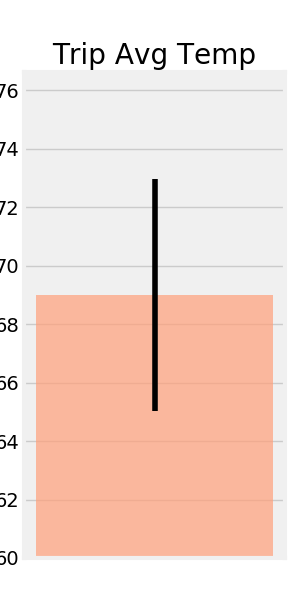

In [53]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='lightsalmon', alpha=0.7)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(60)

plt.show()

In [57]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def collect_rainfall(start_date, end_date):
    return session.query(Measurement.station, 
                         Measurement.prcp.label('rainfall'),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by('rainfall DESC').all()

collect_rainfall('2015-02-16', '2015-03-15')


/anaconda3/lib/python3.6/site-packages/sqlalchemy/sql/compiler.py:643: SAWarning: Can't resolve label reference 'rainfall DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[('USC00514830', 0.13, 21.5213, -157.8374, 7.0),
 ('USC00511918', 0.0, 21.3152, -157.9992, 0.9),
 ('USC00513117', 0.0, 21.4234, -157.8015, 14.6),
 ('USC00516128', 0.0, 21.3331, -157.8025, 152.4),
 ('USC00517948', 0.0, 21.3934, -157.9751, 11.9),
 ('USC00519281', 0.0, 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0, 21.33556, -157.71139, 19.5)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


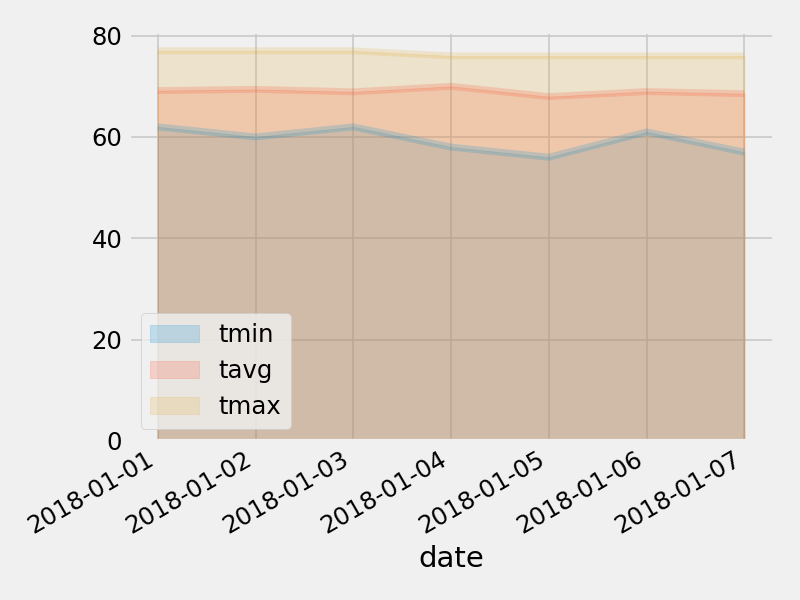

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
